In [ ]:
部署私有仓库应用

1.私有仓库镜像（registry --官方出品，没有图形界面）
Dockerhub 官方提供了容器镜像 registry，用来搭建私有仓库。

# 拉取镜像：
docker pull daocloud.io/library/registry:latest

In [ ]:
2.运行容器
docker run -itd -v /home/dockerdata/registry:/var/lib/registry --name "pri_registry" --restart=always -p 5000:5000 daocloud.io/library/registry:latest
参数解释：
-/home/dockerdata/registry表示宿主机（Host）的目录，如果不存在则自动创建；
-v 映射目录：宿主机的目录：容器目录，将宿主机的目录挂载到容器中，即将数据目录挂载出来，防止docker私有仓库这个容器被删除的时候，仓库里面的镜像也会被删除
-p 端口映射：本地端口：容器端口

2.5 防火墙报错处理
systemctl stop firewalld
apt-get install iptables*
systemctl start iptables
iptables -F
systemctl restart docker

In [ ]:
3.连接容器查看端口状态
docker exec -it 0823df7 /bin/sh
netstat -lntp # 在容器shell中进一步执行
- docker exec 在容器中执行命令，-i 表示interactive，允许与shell进行交互，-t分配一个伪终端，pseudo-TTY,提供终端环境，以便类似本地环境一样与容器交互
- 0823df7 容器的ID，- /bin/sh 在容器中执行的shell
netstat -lntp:在容器中运行的命令，用于查看网络连接状态。
    netstat: 是一个网络工具，用于显示网络连接、路由表、接口统计、伪装连接和多播成员。
    -l: 仅显示处于监听状态（LISTEN）的端口。
    -t: 仅显示 TCP 端口。
    -n: 显示数字形式的地址和端口号，不进行主机名和端口名称的解析。
    -p: 显示与端口关联的进程信息。

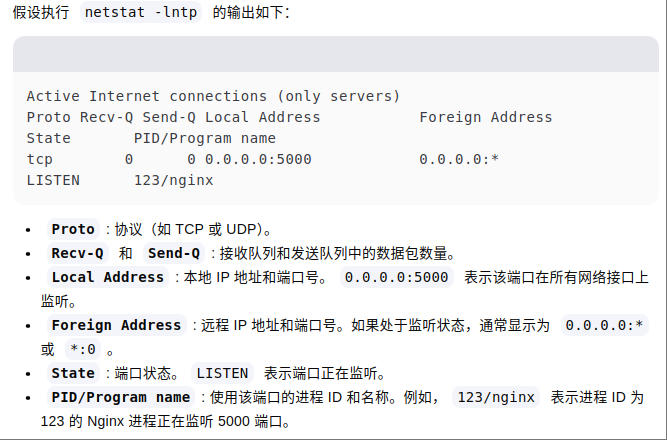

In [1]:
# netstat -lntp 输出如下
from IPython.display import Image
Image(filename="netstat_results.jpg",width=400,height=400)

In [ ]:
# 在本机查看能否访问该私有仓库，看下状态码是不是200
curl -I https://127.0.0.1:5000
或者
curl -I https://localhost:5000

In [ ]:
4.下载测试
docker pull daocloud.io/library/busybox
docker pull daocloud.io/library/mysql

5.上传镜像
#上传镜像之前，必须要给镜像打tag，注明ip和端口
docker tag daocloud.io/library/busybox 192.168.256.141:5000/busybox
docker tag daocloud.io/library/mysql 192.168.246.141:5000/daocloud.io/library/mysql
#tag 后面可以使用 image 名称也可以使用id，如果是官方镜像则不需要加前缀，但是对于私有镜像，比如daocloud.io，在push之前得加前缀
#推送镜像
docker push 10.8.166.252:5000/busybox:latest

In [ ]:
5.5报错处理
如果出现错误：Get https://master.up.com:5000/v1/_ping: http: server gave HTTP response to HTTPS client
意味着没有正确处理 https 的问题，解决方案如下：
1.验证网络连接，确保私有仓库的域名或IP是否可以正常访问
curl -v http://10.8.166.252:5000/v1/_ping 或者
curl -v https://10.8.166.252:5000/v1/_ping
2.确保私有仓库支持HTTPS，如果没有启用，可以考虑安装SSL证书并配置HTTPS
3.在Docker客户端配置使用HTTPS（推荐）
#必要的话，可以在添加镜像，“registry-mirrors”:{"https://...."}
vim /etc/docker/daemon.json
{
    "insecure-registries": ["10.8.166.252:5000"]
}
# 重启docker
sudo systemctl restart docker
4.临时使用HTTP（不安全，仅适用于测试环境）
#如果不想修改 Docker 配置，也可以在推送时临时禁用 HTTPS 检查 
DOCKER_OPTS="--insecure-registry 10.8.166.252:5000" docker push 10.8.166.252:5000/busybox:latest

In [ ]:
#重新上传镜像到私有仓库
docker push 192.168.246.141:5000/busybox
docker push 192.168.246.141:5000/daocloud.io/library/mysql
#宿主机（HOST）查看存放镜像目录
ls /home/dockerdata/registry/docker/registry/v2/repositories/
#查看私有仓库里的所有镜像
curl http://192.168.246.141:5000/v2/_catalog
# 语法 curl https://ip:port/v2/repo名字/tags/list
curl http://192.168.246.141:5000/v2/busybox/tags/list
{"name":"busybox","tags":["latest"]}
curl http://192.168.246.141:5000/v2/daocloud.io/library/mysql/tags/list  
{"name":"daocloud.io/library/mysql","tags":["latest"]} 

6.拉取私有仓库镜像（测试是否上传成功）
#先将刚才打了tags的镜像删掉
docker rmi 192.168.246.141:5000/busybox
#拉取镜像
docker pull 192.168.246.141:5000/busybox
docker images